# Problem Set #5
## Name: Weiwei Zheng

### Problem 1 Multinomial logistic regression and cross validation

In [261]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

import sklearn
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import LeaveOneOut, KFold
from sklearn import metrics 
from sklearn.metrics import classification_report, confusion_matrix
from pylab import rcParams
import statsmodels.api as sm
import scipy.interpolate as intpl

import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline
rcParams['figure.figsize'] = 10, 8
sb.set_style('whitegrid')

In [240]:
drink = pd.read_csv("data/strongdrink.txt")
drink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


***a) multinomial logistic regression***

In [242]:
X = drink[['alco', 'malic', 'tot_phen', 'color_int']]
y = drink[['cultivar']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)
MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
MultLogReg.fit(X_train, y_train)

C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\utils\validation.py:547: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [243]:
coef1 = str(MultLogReg.coef_[0]).strip("[]").split()
coef2 = str(MultLogReg.coef_[1]).strip("[]").split()
coef3 = str(MultLogReg.coef_[2]).strip("[]").split()
print("The coefficients for cultivar = 1 are ", ", ".join(coef1))
print("The coefficients for cultivar = 2 are ", ", ".join(coef2))
print("The coefficients for cultivar = 2 are ", ", ".join(coef3))

The coefficients for cultivar = 1 are  1.7004277, -0.265608, 1.22389495, 0.02275092
The coefficients for cultivar = 2 are  -1.46801429, -0.33305174, 0.66400716, -0.9227103
The coefficients for cultivar = 2 are  -0.23241352, 0.59865973, -1.88790211, 0.89995924


In [244]:
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          1       0.87      1.00      0.93        13
          2       1.00      0.90      0.95        21
          3       1.00      1.00      1.00        10

avg / total       0.96      0.95      0.96        44



In [245]:
print("The error rates for testing set are 0.13, 0, 0 for cultivar = 1, 2, 3 respectively")

The error rates for testing set are 0.13, 0, 0 for cultivar = 1, 2, 3 respectively


In [246]:
drink["cultivar"].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

So the model is best predicting cultivar = 3  which has precision and recall both equal to 1. <br/n>
The most accurately predicted category doesn't have the most observations, cultivar = 2 has more obs.

***b) LOOCV ***

In [247]:
Xvars = drink[['alco', 'malic', 'tot_phen', 'color_int']].values
yvals = drink["cultivar"].values
N_loo = Xvars.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvars)
error_df = DataFrame({"error": np.zeros(N_loo), "y_test": np.zeros(N_loo), "y_pred": np.zeros(N_loo)})

In [248]:
for train_index, test_index in loo.split(Xvars):
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    error_df["y_test"][test_index] = y_test
    error_df["y_pred"][test_index] = y_pred
    error_df["error"][test_index] = (error_df["y_test"][test_index] != \
                                     error_df["y_pred"][test_index]).astype(int) 

In [249]:
print('test estimate MSE_loocv=', error_df["error"].mean())
print('error rate for cultivar = 1 is', error_df[error_df["y_pred"] == 1]["error"].mean())
print('error rate for cultivar = 2 is', error_df[error_df["y_pred"] == 2]["error"].mean())
print('error rate for cultivar = 3 is', error_df[error_df["y_pred"] == 3]["error"].mean())

test estimate MSE_loocv= 0.07954545454545454
error rate for cultivar = 1 is 0.09836065573770492
error rate for cultivar = 2 is 0.08571428571428572
error rate for cultivar = 3 is 0.044444444444444446


The error rates for cultivar = 1 becomes smaller, while the others become larger compared with part a.

***c) k-fold cross validation***

In [250]:
k = 4
kf = KFold(n_splits = k, random_state = 10, shuffle = True )
kf.get_n_splits(Xvars)
error_df_k_total = DataFrame({"error": np.zeros(0), "y_test": np.zeros(0), \
                              "y_pred": np.zeros(0)})

In [251]:
MSE_kf = 0
    
for train_index, test_index in kf.split(Xvars):
    k_ind = 1
    X_train, X_test = Xvars[train_index], Xvars[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    MultLogReg_k = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    MultLogReg_k.fit(X_train, y_train)
    y_pred = MultLogReg.predict(X_test)
    error_df_k = DataFrame({"error": np.zeros(len(test_index)), \
                            "y_test": y_test, "y_pred": y_pred})
    error_df_k['error'] = (error_df_k["y_test"] != error_df_k["y_pred"]).astype(int)
    error_df_k_total = pd.concat([error_df_k_total, error_df_k])    
    MSE_kf += error_df_k["error"].mean()

In [252]:
print('test estimate MSE k-fold=', MSE_kf/k)
print('error rate for cultivar = 1 is', error_df_k_total[error_df_k_total["y_pred"] == 1]["error"].mean())
print('error rate for cultivar = 2 is', error_df_k_total[error_df_k_total["y_pred"] == 2]["error"].mean())
print('error rate for cultivar = 3 is', error_df_k_total[error_df_k_total["y_pred"] == 3]["error"].mean())

test estimate MSE k-fold= 0.06818181818181818
error rate for cultivar = 1 is 0.06779661016949153
error rate for cultivar = 2 is 0.08333333333333333
error rate for cultivar = 3 is 0.044444444444444446


The error rate for cultivar = 1 is larger than part b but smaller than part a, for cultivar = 2 </br>
is smaller than part b but larger than part a, for cultivar = 3 is also smaller than part b but </br>
larger than part a.

### Problem 2 Splines and interpolation

In [253]:
cool = pd.read_csv("data/CoolIndex.txt", names = np.array(["age", "cool_ind"]))
cool.head()
age = cool.age
cool_ind = cool.cool_ind

*** a) scatter plot*** 

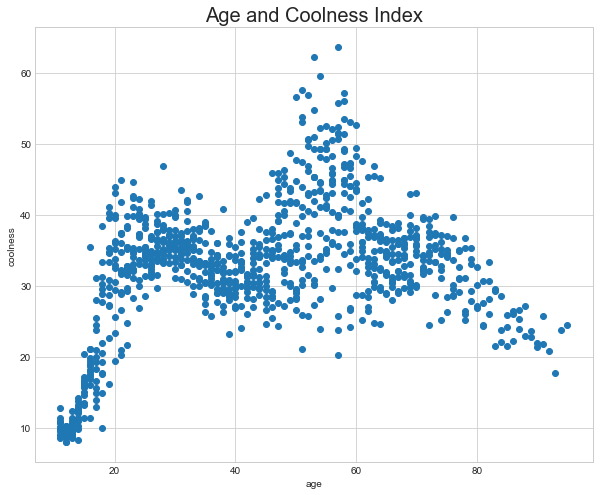

In [254]:
plt.scatter(age, cool_ind)
plt.title('Age and Coolness Index', fontsize=20)
plt.xlabel('age')
plt.ylabel('coolness')
plt.show()

*** d) step-wise function ***

In [255]:
age_bin1 = (age < 22).astype(int)
age_bin2 = ((age >= 22) & (age < 40)).astype(int)
age_bin3 = ((age >= 40) & (age < 59)).astype(int)
age_bin4 = ((age >= 59) & (age < 77)).astype(int)
age_bin5 = (age >= 77).astype(int)
X_step = pd.DataFrame(dict(age_bin1 = age_bin1, age_bin2 = age_bin2, age_bin3 = age_bin3, \
                           age_bin4 = age_bin4, age_bin5 = age_bin5))

In [266]:
step_reg = sm.OLS(endog = cool_ind, exog = X_step, missing='drop')
step_reg_results = step_reg.fit()

In [257]:
b1, b2, b3, b4, b5 = step_reg_results.params
print("Coefficients B1 to B5 for each age bin are ", b1, b2, b3, b4, b5)
print("The predicted value for a 73-year-old is", b4)

Coefficients B1 to B5 for each age bin are  20.1024572521 34.4757880776 37.6351054924 35.2254000402 27.2963782443
The predicted value for a 73-year-old is 35.2254000402


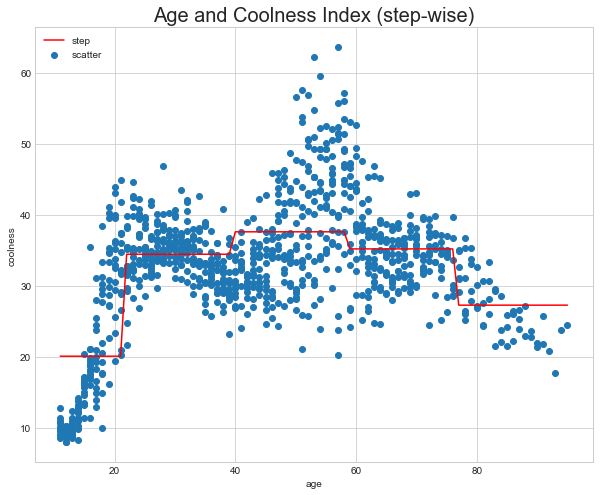

In [272]:
plt.title('Age and Coolness Index (step-wise)', fontsize=20)
plt.xlabel('age')
plt.ylabel('coolness')
plt.scatter(age, cool_ind, label = 'scatter')
plt.plot(age, step_reg_results.predict(X_step), 'r-', label = 'step')
plt.legend(loc='upper left')
plt.show()

***c) linear spline***

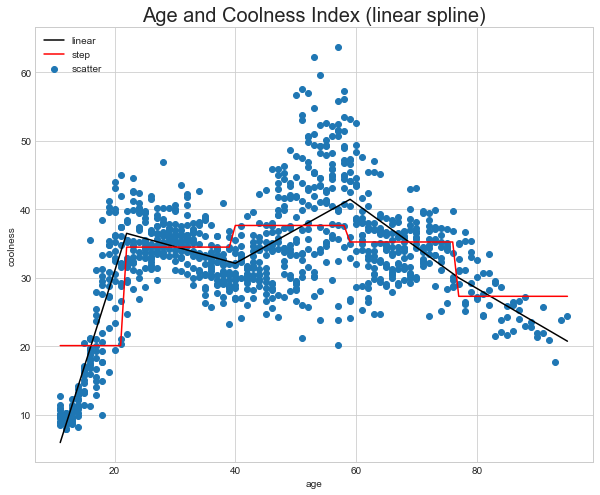

In [273]:
knots = [22, 40, 59, 77]
linear = intpl.LSQUnivariateSpline(age.values, cool_ind.values, knots, k=1)

plt.title('Age and Coolness Index (linear spline)', fontsize=20)
plt.xlabel('age')
plt.ylabel('coolness')
plt.scatter(age, cool_ind, label = 'scatter')
plt.plot(age, linear(age), 'k-', label = 'linear')
plt.plot(age, step_reg_results.predict(X_step), 'r-', label = 'step')
plt.legend(loc='upper left')
plt.show()

In [264]:
print("The predicted value for a 73-year-old is", linear(73))

The predicted value for a 73-year-old is 32.536832389143306


***d) cubic spline***

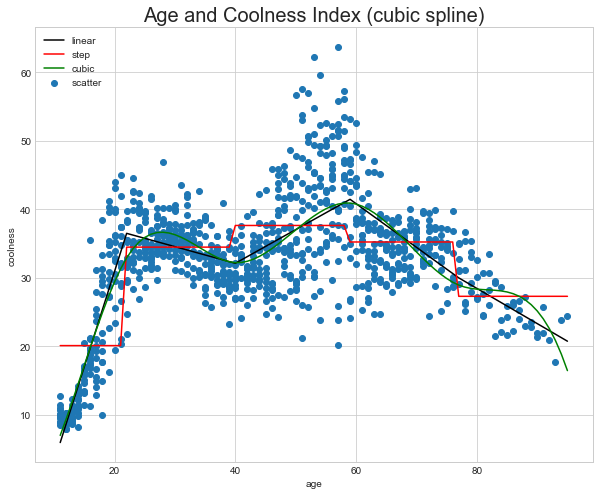

In [274]:
knots = [22, 40, 59, 77]
cubic = intpl.LSQUnivariateSpline(age.values, cool_ind.values, knots, k=3)

plt.title('Age and Coolness Index (cubic spline)', fontsize=20)
plt.xlabel('age')
plt.ylabel('coolness')
plt.scatter(age, cool_ind, label = 'scatter')
plt.plot(age, linear(age), 'k-', label = 'linear')
plt.plot(age, step_reg_results.predict(X_step), 'r-', label = 'step')
plt.plot(age, cubic(age), 'g-', label = 'cubic')
plt.legend(loc='upper left')
plt.show()

In [275]:
print("The predicted value for a 73-year-old is", cubic(73))

The predicted value for a 73-year-old is 31.262429389257864
